In [15]:
#  .\.pyspark\Scripts\activate  # enter this in cmd first to activate the virtual environment
import os
from pyspark.sql import SparkSession
spark_home = r"D:\senior 2 term 2\bigdata\releatedStuffforeEnviroment\spark_unzipped"
os.environ["SPARK_HOME"] = spark_home

# Add Spark bin and executors to PATH
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "bin")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "sbin")

# Add Spark Python libraries to PYTHONPATH
os.environ["PYTHONPATH"] = os.path.join(spark_home, "python") + os.pathsep + os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] += os.pathsep + os.path.join(spark_home, "python", "lib")

# Add PySpark to the system path
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "pyspark.zip")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "py4j-0.10.9-src.zip")

os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'
# Test the setup

# Create a SparkSession
spark = SparkSession.builder \
    .appName("PySpark-Script") \
    .getOrCreate()

In [33]:
df = spark.read.csv("preprocessing_spark_output2.csv", header=True, inferSchema=True)
df_salary=spark.read.csv("almostdone.csv",header=True,inferSchema=True)


In [34]:
df.printSchema()


root
 |-- id: string (nullable = true)
 |-- sourceCC: string (nullable = true)
 |-- source: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- position_name: string (nullable = true)
 |-- position_workType: string (nullable = true)
 |-- position_careerLevel: string (nullable = true)
 |-- position_department: string (nullable = true)
 |-- orgAddress_addressLine: string (nullable = true)
 |-- orgAddress_level: string (nullable = true)
 |-- orgAddress_country: string (nullable = true)
 |-- orgAddress_state: string (nullable = true)
 |-- orgAddress_city: string (nullable = true)
 |-- orgCompany_nameOrg: string (nullable = true)
 |-- orgCompany_homepage: string (nullable = true)
 |-- url: string (nullable = true)
 |-- orgTags_CATEGORIES: string (nullable = true)
 |-- orgTags_REQUIREMENTS: string (nullable = true)
 |-- orgTags_SKILLS: string (nullable = true)
 |-- years_or_months_experience: string (nullable = true)
 |-- todo: string (nullable = true)
 |-- _c21: string (null

In [35]:
df_salary.printSchema()
df_salary.show()

root
 |-- salary: string (nullable = true)
 |-- sourceCC: string (nullable = true)
 |-- source: string (nullable = true)
 |-- text: string (nullable = true)
 |-- html: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- position_name: string (nullable = true)
 |-- position_workType: string (nullable = true)
 |-- position_careerLevel: string (nullable = true)
 |-- position_department: string (nullable = true)
 |-- orgAddress_addressLine: string (nullable = true)
 |-- orgAddress_level: string (nullable = true)
 |-- orgAddress_country: string (nullable = true)
 |-- orgAddress_state: string (nullable = true)
 |-- orgAddress_city: string (nullable = true)
 |-- orgCompany_nameOrg: string (nullable = true)
 |-- orgCompany_homepage: string (nullable = true)
 |-- url: string (nullable = true)
 |-- orgTags_CATEGORIES: string (nullable = true)
 |-- orgTags_REQUIREMENTS: string (nullable = true)
 |-- orgTags_SKILLS: string (nullable = true)
 |-- salary_text: string (nullable = true

In [62]:
#salary model prediction
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt


df_filtered = df_salary.dropna(subset=['salary', 'orgTags_SKILLS'])
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains("['"))
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains("0")==False)
df_filtered=df_filtered.filter(df_filtered.salary.contains('NOT FOUND')==False) 
df_filtered=df_filtered.select('orgTags_SKILLS','salary')
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains('NOT FOUND')==False)
#the salary column should only contain numbers so any letters should be remove
df_filtered=df_filtered.withColumn("salary",df_filtered["salary"].cast("int"))
df_filtered=df_filtered.filter(df_filtered.salary<50000)

df_filtered.printSchema()
df_filtered.show()
plt.boxplot(df_filtered.toPandas()['salary'])
plt.show()
# #############################################################################################################
df_pd = df_filtered.toPandas()

# Apply ast.literal_eval correctly
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(ast.literal_eval)
#normalize the orgTags_SKILLS all small
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.lower() for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace(" ","") for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace("(","") for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace(")","") for y in x])

df_pd.to_csv('salaryAndskills.csv', index=False)    


print(len(df_pd['orgTags_SKILLS']))
print(len(df_pd['salary']))
print(df_pd['orgTags_SKILLS'][0])
# One hot encode the orgTags_SKILLS
mlb = MultiLabelBinarizer()
df_pd = df_pd.join(pd.DataFrame(mlb.fit_transform(df_pd.pop('orgTags_SKILLS')),
                          columns=mlb.classes_,
                          index=df_pd.index))
df_pd.to_csv('testing.csv', index=False)
modelsalary = LinearRegression()
X = df_pd.drop('salary', axis=1)

y = df_pd['salary']

modelsalary.fit(X, y)
y_pred = modelsalary.predict(X)
print("error",mean_squared_error(y, y_pred))
plt.scatter(y, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# #input data to predict




+--------------------+------------------+
|      orgTags_SKILLS|            salary|
+--------------------+------------------+
|['Adobe Dreamweav...|              3041|
|    'Writing skills'| 5833.333333333333|
| ""Associate's de...|4026.1666666666665|
| 'Microsoft Power...| 5098.083333333333|
|['Adobe Creative ...|            5061.5|
|     ['Photography']|              3200|
| and location. Re...|              5000|
|['Photography', '...|              2400|
|['FTP', 'Photogra...|2991.1666666666665|
|   'Interior design'|              3680|
|['AutoCAD', 'Inte...| 4426.583333333333|
|['AutoCAD', 'Adob...|            3838.5|
|           'AutoCAD'|4026.3333333333335|
| ""Bachelor's deg...| 5266.666666666667|
|        ['ArchiCAD']| 4467.666666666667|
|   'Adobe Photoshop'| 4166.666666666667|
|  'Microsoft Office'|              1920|
| 'Microsoft Power...| 4325.916666666667|
|       'Photography'|2910.8333333333335|
|   'Adobe Photoshop'| 4508.583333333333|
+--------------------+------------

In [38]:
def make_prediction_salary(skill_list):
    # Normalize the input
    skill_list = [skill.lower().replace(" ", "").replace("(", "").replace(")", "") for skill in skill_list]
    
    # Transform the skills using the same mlb instance
    try:
        transformed_skills = mlb.transform([skill_list])
    except ValueError:
        print("Error: This skill was not seen in the training data and cannot be processed.")
        return None

    # Create a DataFrame 
    input_df = pd.DataFrame(transformed_skills, columns=mlb.classes_)

    # Predict using the trained model
    prediction = modelsalary.predict(input_df)
    prediction = max(0, prediction)

    return prediction

predicted_salary = make_prediction_salary(['figma, adobe xd'])
if predicted_salary is not None:
    print("Predicted salary:", predicted_salary[0])

Predicted salary: 5826.222470580436


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['figma,adobexd'] will be ignored
  warnings.warn(


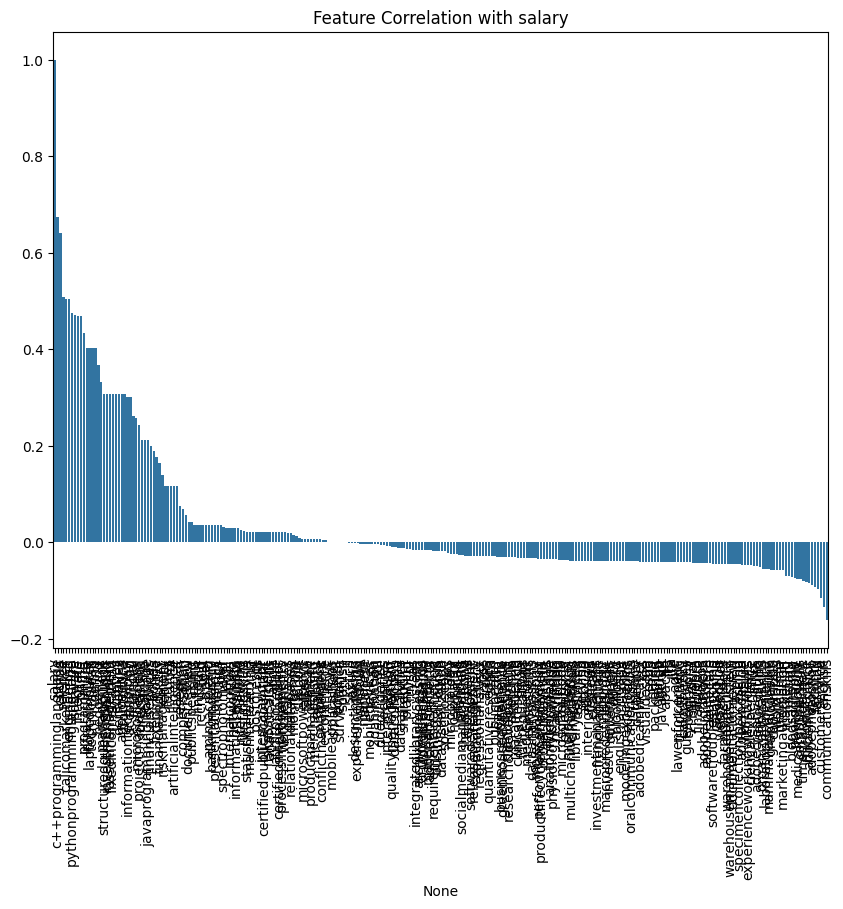

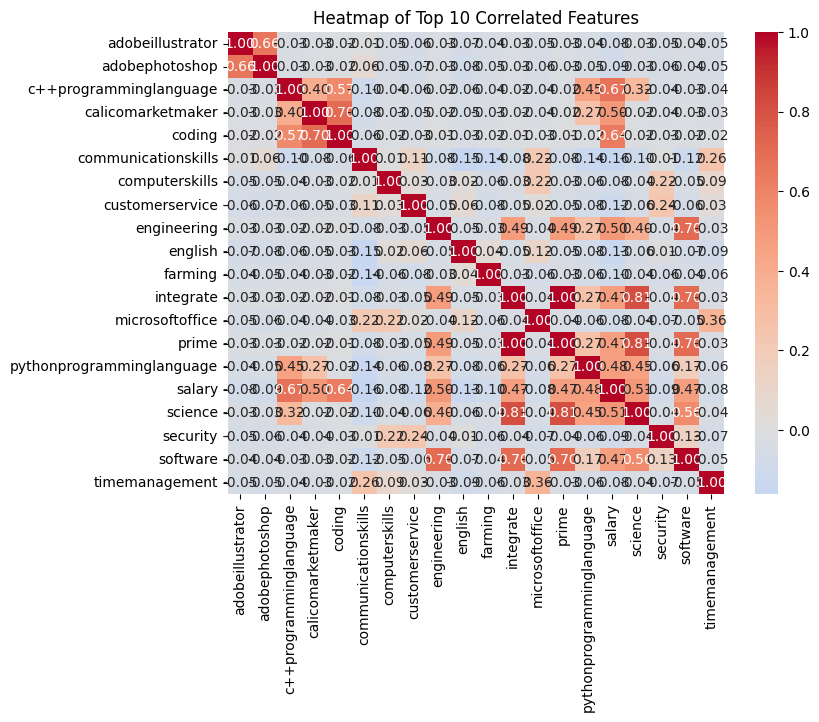

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df_full = pd.concat([X, y], axis=1)

#  correlation matrix
corr_matrix = df_full.corr()

# The target variable slaary
target_corr = corr_matrix['salary'].sort_values(ascending=False)

# Plotting the correlations of the most correlated features
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.title('Feature Correlation with salary')
plt.show()

top_positive = target_corr.head(10).index  # Top 10 positive correlations
top_negative = target_corr.tail(10).index  # Top 10 negative correlations
top_features = top_positive.union(top_negative)  # Combine top positive and negative
filtered_corr_matrix = df_full[top_features].corr()

# Plotting the focused heatmap
plt.figure(figsize=(8, 6))  
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Heatmap of Top 10 Correlated Features')
plt.show()




root
 |-- orgTags_SKILLS: string (nullable = true)
 |-- years_or_months_experience: integer (nullable = true)

+--------------------+--------------------------+
|      orgTags_SKILLS|years_or_months_experience|
+--------------------+--------------------------+
|['Adobe Creative ...|                         3|
|     ['Photography']|                         3|
|['Photography', '...|                         3|
|['Photography', '...|                         1|
|['Adobe Photoshop...|                         1|
|['Typography', 'A...|                         3|
|['Adobe Photoshop...|                         3|
|['Leadership', 'C...|                         4|
|['Axure', 'Mobile...|                         4|
|['Microsoft Power...|                         5|
|['Quality managem...|                         8|
|['Writing skills'...|                         1|
|['Project plannin...|                         8|
|['Microsoft Power...|                         5|
|['Node.js', 'Engl...|                 

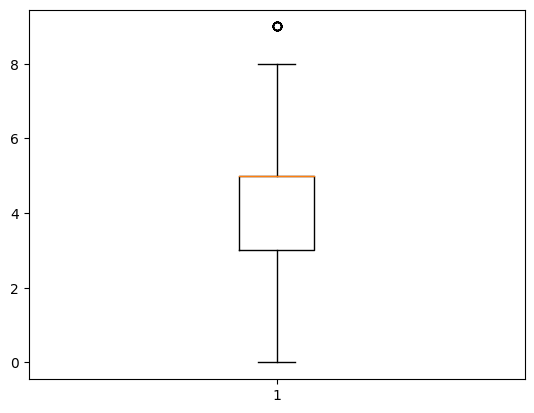

1153
1153
['adobecreativesuite', 'graphicdesign', 'figma', 'adobeaftereffects', 'multichannelmarketing', 'html5', 'timemanagement']
0.13822339397241556


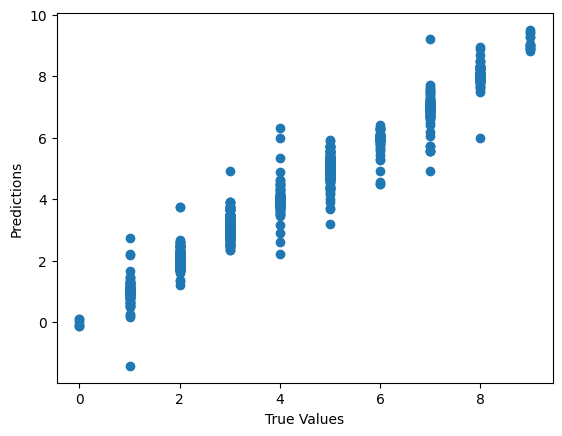

In [43]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt


df_filtered = df.dropna(subset=['years_or_months_experience', 'orgTags_SKILLS'])
df_filtered=df_filtered.filter(df_filtered.years_or_months_experience.contains('years'))
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains("['"))
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains("0")==False)
df_filtered=df_filtered.filter(df_filtered.years_or_months_experience.contains('NOT FOUND')==False) 
df_filtered=df_filtered.select('orgTags_SKILLS','years_or_months_experience')
df_filtered=df_filtered.filter(df_filtered.orgTags_SKILLS.contains('NOT FOUND')==False)
from pyspark.sql.functions import regexp_replace, col
df_filtered = df_filtered.withColumn(
    "years_or_months_experience",
    regexp_replace(col("years_or_months_experience"), r"\s*years\s*", "").cast("integer")
)
df_filtered = df_filtered.filter(df_filtered.years_or_months_experience<10)

df_filtered.printSchema()
df_filtered.show()
plt.boxplot(df_filtered.toPandas()['years_or_months_experience'])
plt.show()
#############################################################################################################
df_pd = df_filtered.toPandas()

# Apply ast.literal_eval correctly
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(ast.literal_eval)
#normalize the orgTags_SKILLS all small
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.lower() for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace(" ","") for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace("(","") for y in x])
df_pd['orgTags_SKILLS'] = df_pd['orgTags_SKILLS'].apply(lambda x: [y.replace(")","") for y in x])

df_pd.to_csv('yearsAndSkills.csv', index=False)    


print(len(df_pd['orgTags_SKILLS']))
print(len(df_pd['years_or_months_experience']))
print(df_pd['orgTags_SKILLS'][0])
# One hot encode the orgTags_SKILLS
mlb = MultiLabelBinarizer()
df_pd = df_pd.join(pd.DataFrame(mlb.fit_transform(df_pd.pop('orgTags_SKILLS')),
                          columns=mlb.classes_,
                          index=df_pd.index))
df_pd.to_csv('testing.csv', index=False)
model = LinearRegression()
X = df_pd.drop('years_or_months_experience', axis=1)

y = df_pd['years_or_months_experience']

model.fit(X, y)
y_pred = model.predict(X)
print(mean_squared_error(y, y_pred))
plt.scatter(y, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#input data to predict




In [ ]:
def make_prediction(skill_list):
    skill_list = [skill.lower().replace(" ", "").replace("(", "").replace(")", "") for skill in skill_list]
    
    try:
        transformed_skills = mlb.transform([skill_list])
    except ValueError:
        print("Error: This skill was not seen in the training data and cannot be processed.")
        return None

    input_df = pd.DataFrame(transformed_skills, columns=mlb.classes_)

    prediction = model.predict(input_df)
    prediction = max(0, prediction)

    return prediction

predicted_years = make_prediction(['figma, adobe xd'])
if predicted_years is not None:
    print("Predicted years of experience:", predicted_years)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_full = pd.concat([X, y], axis=1)

corr_matrix = df_full.corr()

target_corr = corr_matrix['years_or_months_experience'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.title('Feature Correlation with Years of Experience')
plt.show()

top_positive = target_corr.head(10).index  # Top 10 positive correlations
top_negative = target_corr.tail(10).index  # Top 10 negative correlations
top_features = top_positive.union(top_negative)  # Combine top positive and negative
filtered_corr_matrix = df_full[top_features].corr()

plt.figure(figsize=(8, 6))  # Smaller figure size
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Heatmap of Top 10 Correlated Features')
plt.show()




In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
df_revomJobna = df.dropna(subset=["position_name"])
job_names = df_revomJobna.select("position_name")
text_data = job_names.rdd.map(lambda row: row.position_name).collect()
# Generate word cloud
print(text_data)
text_data = ",".join(text_data)
print(text_data[1:100])
wordcloud = WordCloud(background_color="white").generate(text_data)

# Display the cloud
plt.figure(figsize=(100,80))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
df_revomJobna = df.dropna(subset=["orgAddress_state"])
job_state = df_revomJobna.select("orgAddress_state")
job_state.show(5)
text_data = job_state.rdd.map(lambda row: row.orgAddress_state).collect()
text_string = " ".join(text_data)
# Generate word cloud
wordcloud = WordCloud(background_color="white").generate(text_string)

# Display the cloud
plt.figure(figsize=(100, 80))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from pyspark.sql.functions import regexp_replace, col

# Drop rows where 'years_or_months_experience' is null
df_remove_null = df.dropna(subset=["years_or_months_experience"])


# Filter rows where 'years_or_months_experience' contains 'years'
job_years = df_remove_null.filter(df_remove_null['years_or_months_experience'].contains('years'))
job_years=job_years.filter(job_years['years_or_months_experience'].contains('=')==False)

# Clean up the 'years_or_months_experience' column
from pyspark.sql.functions import regexp_replace, col
job_years = job_years.withColumn(
    "years_experience",
    regexp_replace(col("years_or_months_experience"), r"\s*years\s*", "").cast("integer")
)
job_years = job_years.filter(job_years.years_experience.isNotNull())

plt.boxplot(job_years.select("years_experience").rdd.flatMap(lambda x: x).collect())
plt.show()



In [ ]:

job_years=job_years.filter(job_years.years_experience<25)
plt.boxplot(job_years.select("years_experience").rdd.flatMap(lambda x: x).collect())


In [ ]:
df_remove_null = df.dropna(subset=["orgTags_SKILLS"])
job_skills = df_remove_null.select("orgTags_SKILLS")
job_skills=job_skills.filter(job_skills['orgTags_SKILLS'].contains('NOT FOUND')==False)
job_skills.show(5)
job_skills = job_skills.rdd.map(lambda row: row.orgTags_SKILLS).collect()
text_data = ",".join(job_skills)
text_data = text_data.replace("'", "")
text_data = text_data.replace('"', "")
print(text_data[1:100])
wordcloud = WordCloud(background_color="white").generate(text_data)
plt.figure(figsize=(100,80))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
df_remove_null = df.dropna(subset=["orgTags_REQUIREMENTS"])
job_skills = df_remove_null.select("orgTags_REQUIREMENTS")
job_skills=job_skills.filter(job_skills['orgTags_REQUIREMENTS'].contains('NOT FOUND')==False)
job_skills.show(5)
job_names = job_skills.rdd.map(lambda row: row.orgTags_REQUIREMENTS).collect()
text_data = ",".join(job_names)
text_data = text_data.replace("'", "")
text_data = text_data.replace('"', "")
print(text_data[1:100])
wordcloud = WordCloud(background_color="white").generate(text_data)
plt.figure(figsize=(100,80))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
df_remove_null = df.dropna(subset=["todo"])
job_skills = df_remove_null.select("todo")
job_skills=job_skills.filter(job_skills['todo'].contains('NOT FOUND')==False)
job_skills.show(5)
job_names = job_skills.rdd.map(lambda row: row.todo).collect()
text_data = ",".join(job_names)
text_data = text_data.replace("'", "")
text_data = text_data.replace('"', "")
print(text_data[1:100])
wordcloud = WordCloud(background_color="white").generate(text_data)
plt.figure(figsize=(100,80))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
df = spark.read.csv("preprocessing_spark_output2.csv", header=True, inferSchema=True)
df_revomJobna = df.dropna(subset=["position_name"])
job_names = df_revomJobna.select("position_name")
job_names.show(5)
df_endcode_job = pd.get_dummies(job_names.toPandas())

#will filter the years of experience form df_revomJobna

df_remove_null = df_revomJobna.dropna(subset=["years_or_months_experience"])


# Filter rows where 'years_or_months_experience' contains 'years'
job_years = df_remove_null.filter(df_remove_null['years_or_months_experience'].contains('years'))
job_years=job_years.filter(job_years['years_or_months_experience'].contains('=')==False)

# Clean up the 'years_or_months_experience' column
job_years = job_years.withColumn(
    "years_experience",
    regexp_replace(col("years_or_months_experience"), r"\s*years\s*", "").cast("integer")
)
job_years = job_years.filter(job_years.years_experience.isNotNull())
job_years=job_years.filter(job_years.years_experience<25)
job_years_filtered =job_years.select("years_experience")
job_years_filtered.show(5)
scaler = MinMaxScaler()
job_years_filtered['years_experience'] = scaler.fit_transform(job_years_filtered[['years_experience']])
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.heatmap(job_years_filtered.toPandas(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heat Map of Job Titles and Years of Experience')




In [ ]:
spark.stop()